In [21]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

dataset_path = "/input/facemask-ds"
annotations_path = os.path.join(dataset_path, "annotations")
images_path = os.path.join(dataset_path, "images")

output_base = "/kaggle/working/face_mask_classification"
os.makedirs(output_base, exist_ok=True)

class_dirs = ["with_mask", "without_mask", "mask_incorrect"]
for cls in class_dirs:
    os.makedirs(os.path.join(output_base, "train", cls), exist_ok=True)
    os.makedirs(os.path.join(output_base, "val", cls), exist_ok=True)
    os.makedirs(os.path.join(output_base, "test", cls), exist_ok=True)

label_mapping = {
    "with_mask": "with_mask",
    "without_mask": "without_mask",
    "mask_weared_incorrect": "mask_incorrect"
}

annotations = []
for xml_file in os.listdir(annotations_path):
    tree = ET.parse(os.path.join(annotations_path, xml_file))
    root = tree.getroot()

    filename = root.find("filename").text
    label = None

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name in label_mapping:
            label = label_mapping[class_name]
            break  # Use the first detected label

    if label:
        annotations.append((filename, label))

# Convert to DataFrame
df = pd.DataFrame(annotations, columns=["filename", "label"])
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset

# Split dataset (80% train, 10% val, 10% test)
train_split = int(0.8 * len(df))
val_split = int(0.9 * len(df))

df_train = df[:train_split]
df_val = df[train_split:val_split]
df_test = df[val_split:]

# Function to move images
def move_images(df, split):
    for _, row in df.iterrows():
        src = os.path.join(images_path, row["filename"])
        dst = os.path.join(output_base, split, row["label"], row["filename"])
        if os.path.exists(src):
            shutil.copy(src, dst)


move_images(df_train, "train")
move_images(df_val, "val")
move_images(df_test, "test")

print("✅ Dataset organized for classification!")

✅ Dataset organized for classification!


In [23]:

dataset_dir = "/kaggle/working/face_mask_classification"

# Load images into TensorFlow dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    image_size=(224, 224),
    batch_size=32
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    image_size=(224, 224),
    batch_size=32
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    image_size=(224, 224),
    batch_size=32
)
class_names = train_dataset.class_names

Found 846 files belonging to 3 classes.
Found 230 files belonging to 3 classes.
Found 229 files belonging to 3 classes.


In [24]:
# Load Pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[-20:]:  
    layer.trainable = True

# Build Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),  # Increase dropout to reduce overfitting
    tf.keras.layers.Dense(3, activation="softmax")  # 3 classes
])

# Compile & Train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [25]:
# Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7369 - loss: 0.7125 - val_accuracy: 0.7826 - val_loss: 0.6212
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9247 - loss: 0.2220 - val_accuracy: 0.8174 - val_loss: 0.5994
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.9553 - loss: 0.1271 - val_accuracy: 0.8304 - val_loss: 0.5016
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9777 - loss: 0.0813 - val_accuracy: 0.8391 - val_loss: 0.4539
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9944 - loss: 0.0403 - val_accuracy: 0.8609 - val_loss: 0.3983
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 0.8696 - val_loss: 0.3533
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.8913 - val_loss: 0.3397
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9986 - loss: 0.0107 - val_accuracy: 0.89

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


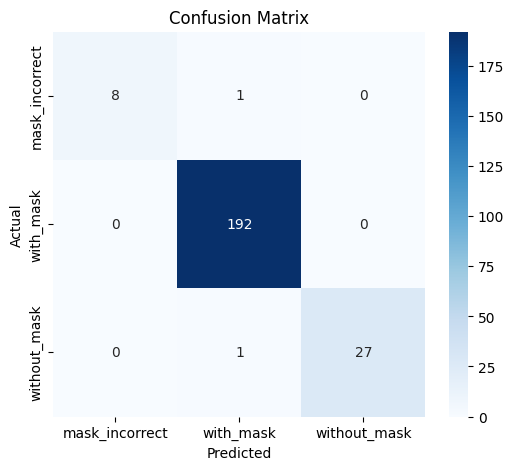

                precision    recall  f1-score   support

mask_incorrect       1.00      0.89      0.94         9
     with_mask       0.99      1.00      0.99       192
  without_mask       1.00      0.96      0.98        28

      accuracy                           0.99       229
     macro avg       1.00      0.95      0.97       229
  weighted avg       0.99      0.99      0.99       229



In [26]:
# Get ground truth and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [27]:
# Save model
model.save("/kaggle/working/face_mask_model.h5")

# Reload model 
loaded_model = tf.keras.models.load_model("/kaggle/working/face_mask_model.h5")

# Check Model Summary
loaded_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,693 (9.87 MB)

 Trainable params: 2,552,579 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2 (12.00 B)

In [43]:
class_names = train_dataset.class_names

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Raw Predictions: [[0.00155925 0.35613105 0.64230967]]
Predicted Class Index: 2


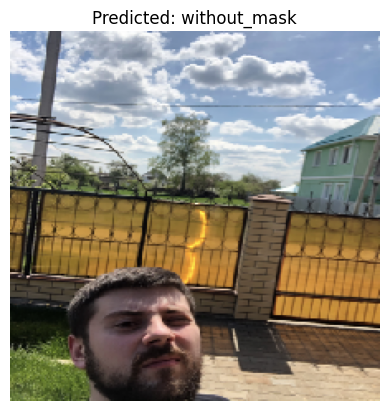

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load single test image
img_path = "/kaggle/working/face_mask_classification/val/without_mask/maksssksksss95.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Convert to batch format
img_array = img_array / 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions)  

# Debugging: Check predictions
print("Raw Predictions:", predictions)
print("Predicted Class Index:", predicted_index)

# Map index to class name
predicted_class = class_names[predicted_index]

# Show result
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [29]:
# Convert model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model
tflite_model_path = "/kaggle/working/face_mask_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model converted to TFLite: {tflite_model_path}")


Saved artifact at '/tmp/tmpk57cc2sl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_805')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138311171337456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311171334288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311171332880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063047328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063649472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063044688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063636624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063637680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063642080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138311063639440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383157798